# Comparaison des titres des publications scientifiques entre deux sources distinctes

Ce notebook a pour objectif de comparer les titres de publications scientifiques entre deux sources distinctes :


## À propos des fichiers d’entrée

⚠️ **L’utilisateur doit remplacer les fichiers fournis (`doc1`, `doc2`) par ses propres fichiers.**

- Le chemin vers chaque fichier doit être précisé dans les cellules concernées.
- Le code fonctionne avec différents formats : **Excel (.xlsx), CSV (.csv), JSON (.json), XML (.xml)**.

Voici quelques exemples d’adaptation à faire en fonction du format :
- df = pd.read_csv("chemin/vers/mon_fichier.csv")
- df = pd.read_excel("chemin/vers/mon_fichier.xlsx")
- df = pd.read_json("chemin/vers/mon_fichier.json")
- df = pd.read_xml("chemin/vers/mon_fichier.xml")  # nécessite pandas >= 1.3.0


L’**objectif** est de détecter automatiquement les correspondances potentielles entre titres dans les deux fichiers, afin d’identifier :

* les titres similaires ou identiques,

* les correspondances les plus pertinentes (avec un seuil de similarité),

* la robustesse des différentes méthodes d’appariement textuel.

Plusieurs approches de traitement du langage naturel (NLP) et de comparaison de similarité textuelle sont explorées :

**TF-IDF + Cosine Similarity** : Vectorisation des titres suivie d’un calcul de similarité cosinus.

**Fuzzy Matching (RapidFuzz)** : Appariement approximatif basé sur des mesures token_sort_ratio et token_set_ratio.

**FAISS (Facebook AI Similarity Search)** : Recherche de plus proches voisins dans un espace vectoriel réduit (TF-IDF + index).

**TF-IDF + LSA (Latent Semantic Analysis)** : Réduction de dimension par SVD avant calcul de similarité cosinus.

**FastText (Gensim)** : Apprentissage de représentations vectorielles de mots et moyenne pour chaque titre, suivie d’une similarité cosinus.

### 1️⃣ TF-IDF + Cosine Similarity (Sklearn)

🔹 Avantage : Gère bien les différences légères dans les titres.

🔹 Inconvénient : Peut être lent sur un très grand volume de données.

***Paramètres à ajuster pour améliorer les résultats:***

🔹 Seuil de Similarité (best_score > 0.5)
        Par défaut, j’ai mis 0.5 mais tu peux tester 0.4 ou 0.6 en fonction du niveau de bruit dans les titres.

🔹 Analyseur du Vectorizer (analyzer='word')
        'word' : Comparaison basée sur les mots (meilleure pour les titres de publications).
        'char' ou 'char_wb' : Basé sur les caractères, utile pour des correspondances plus fines.

🔹 Suppression des Stop-Words (stop_words='english')
        Supprime les mots comme "the", "of", "and", qui n'apportent pas de sens.
        Peut être désactivé si tes titres contiennent peu de mots-clés.

🔹 N-Gram (ngram_range=(1, 2))
        (1,1): Mots seuls
        (1,2): Mots seuls + Paires de mots (utile si certains mots sont toujours associés)
        (2,2): Uniquement paires de mots (moins précis)

🔹 Utilisation d’un Stemmer ou Lemmatizer (optionnel)
     Si les titres ont des variations grammaticales (ex: "analyzing" vs "analysis"), on peut lemmatiser ou réduire les mots à leur racine.

In [3]:
#pip install pandas scikit-learn

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Chargement des fichiers
doc1 = pd.read_excel("chemin/vers/doc1.xlsx")  # Remplacer par le chemin réel
doc2 = pd.read_excel("chemin/vers/doc2.xlsx")  # Remplacer par le chemin réel
doc2["id"] = doc2["id"].astype(str)

# Convertir les titres et récupérer les IDs
titles_doc1 = doc1["Title"].astype(str).tolist()
titles_doc2 = doc2["form_title"].astype(str).tolist()
ids_doc2 = doc2["id"].tolist()  # Assure-toi que la colonne "id" existe dans doc2

# Initialisation du Vectorizer
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')

# Construction de la matrice TF-IDF
tfidf_matrix = vectorizer.fit_transform(titles_doc1 + titles_doc2)

# Séparation des matrices
tfidf_doc1 = tfidf_matrix[:len(titles_doc1)]
tfidf_doc2 = tfidf_matrix[len(titles_doc1):]

# Calcul de la similarité cosinus
cosine_sim = cosine_similarity(tfidf_doc1, tfidf_doc2)

# Récupérer les meilleurs matchs
matches = []
match_count = {}

for i, titre in enumerate(titles_doc1):
    best_idx = np.argmax(cosine_sim[i])
    best_score = cosine_sim[i][best_idx]
    
    if best_score > 0.7:  # Seuil ajustable
        match_title = titles_doc2[best_idx]
        match_id = ids_doc2[best_idx]
        
        matches.append((titre, match_title, match_id, best_score))
        match_count[titre] = match_count.get(titre, 0) + 1

# Création du DataFrame
matched_df_tfidf2 = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])

# Ajout du nombre d'occurrences
matched_df_tfidf2["nbre_occurences"] = matched_df_tfidf2["titre_doc1"].map(match_count).astype(str)

# Exportation des résultats
matched_df_tfidf2.to_excel("resultats_tfidf2.xlsx", index=False)

# Affichage
matched_df_tfidf2


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,titre_doc_acm,titres_similaires_revconf,id_rev,Score,nbre_occurences
0,"ACM Conference on Health, Inference, and Learning","Conference on Health, Inference, and Learning",19386,0.986805,1
1,Annual Computer Security Applications Conference,Annual Computer Security Applications Conference,4258,1.000000,1
2,"AAAI/ACM Conference on AI, Ethics, and Society","AAAI/ACM Conference on AI, Ethics, and Society",6742,1.000000,1
3,IEEE/ACM International Conference on Automated...,IEEE/ACM International Conference on Automated...,3708,1.000000,1
4,ACM Asia Conference on Computer and Communicat...,ACM Asia Conference on Computer and Communicat...,341,1.000000,1
...,...,...,...,...,...
162,ACM Web Science Conference,ACM International Conference on Web Science,3887,0.970985,1
163,IEEE/WIC/ACM International Conference on Web I...,IEEE/WIC/ACM International Conference on Web I...,3681,1.000000,1
164,ACM Conference on Security and Privacy in Wire...,ACM Conference on Security and Privacy in Wire...,4507,1.000000,1
165,ACM International Conference on Web Search and...,ACM International Conference on Web Search and...,2072,1.000000,1


In [3]:
matched_df_tfidf2.describe(include='all')

,titre_doc_acm,titres_similaires_revconf,id_rev,Score,nbre_occurences
count,167,167,167,167.000000,167
unique,167,156,156,NaN,1
top,"ACM Conference on Health, Inference, and Learning",International Conference of Machine Learning,969,NaN,1
freq,1,3,3,NaN,167
mean,NaN,NaN,NaN,0.948220,NaN
std,NaN,NaN,NaN,0.085258,NaN
min,NaN,NaN,NaN,0.706915,NaN
25%,NaN,NaN,NaN,0.935758,NaN
50%,NaN,NaN,NaN,1.000000,NaN
75%,NaN,NaN,NaN,1.000000,NaN


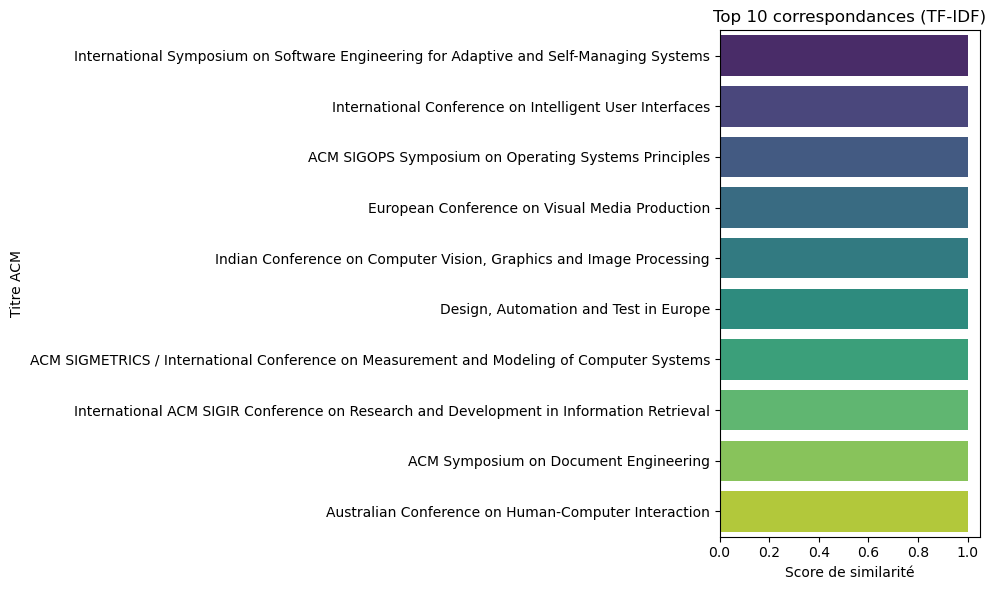

In [19]:
top_matches = matched_df_tfidf2.sort_values(by="Score", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_matches, x="Score", y="titre_doc_acm", palette="viridis")
plt.title("Top 10 correspondances (TF-IDF)")
plt.xlabel("Score de similarité")
plt.ylabel("Titre ACM")
plt.tight_layout()
plt.show()


### 2️⃣  RapidFuzz (Alternative à FuzzyWuzzy)

🔹 ***Avantages*** : Plus rapide et efficace que fuzzywuzzy.

🔹 ***Inconvénients*** : Moins performant que TF-IDF pour les longues phrases.


Tests sur plusieurs scorers en fonction du type de variations que je rencontre dans les titres :

🔹 ***fuzz.token_sort_ratio*** : Bon pour les titres où l'ordre des mots peut changer, mais où tous les mots sont importants.
   
🔹 ***fuzz.token_set_ratio*** : Utile si certains mots peuvent être présents en double ou en trop dans un titre.
   
🔹 ***fuzz.partial_ratio*** : Utile si un titre peut être une sous-partie d’un autre.
   
🔹 ***fuzz.ratio*** : Comparaison classique caractère par caractère.

Dans notre cas:  token_sort_ratio est un bon choix si les mots sont les mêmes mais dans un ordre différent. Mais si certains titres contiennent des mots supplémentaires inutiles (comme "Proceedings of..."), token_set_ratio peut être plus adapté.

In [7]:
#pip install pandas rapidfuzz

#### RATIO fuzz.token_sort_ratio

In [9]:
from rapidfuzz import process, fuzz
import pandas as pd

# Chargement des fichiers
doc1 = pd.read_excel("chemin/vers/doc1.xlsx")  # Remplacer par le chemin réel
doc2 = pd.read_excel("chemin/vers/doc2.xlsx")  # Remplacer par le chemin réel

# Assurer que la colonne "id" est bien au format string
doc2["id"] = doc2["id"].astype(str)

matches = []
match_count = {}

# Comparaison fuzzy
for titre in doc1["Title"]:
    match, score, idx = process.extractOne(titre, doc2["form_title"], scorer=fuzz.token_sort_ratio)
    
    if score > 70:  # Seuil ajustable
        match_id = doc2.iloc[idx]["id"]  # Récupération de l'ID associé
        
        matches.append((titre, match, match_id, score))
        match_count[titre] = match_count.get(titre, 0) + 1

# Création du DataFrame
matched_df_fuzzy_sort_ratio2 = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])

# Ajout de la colonne du nombre d'occurrences
matched_df_fuzzy_sort_ratio2["nbre_occurences"] = matched_df_fuzzy_sort_ratio2["titre_doc1"].map(match_count).astype(str)

# Sauvegarde des résultats
matched_df_fuzzy_sort_ratio2.to_excel("resultats_fuzzy_sort_ratio2.xlsx", index=False)

# Affichage
matched_df_fuzzy_sort_ratio2


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,titre_doc_acm,titres_similaires_revconf,id_rev,Score,nbre_occurences
0,"International Conference on Algorithms, Comput...",International Conference on Artificial Intelli...,4637,80.882353,1
1,Australasian Computing Education Conference,Australasian Computer-Human Interaction Confer...,19308,79.569892,1
2,International Conference on Animal-Computer In...,International Conference on Compiler Construction,178,82.692308,1
3,International Virtual Conference on Applied Co...,International Conference on Information and Co...,19593,81.118881,1
4,"ACM Conference on Health, Inference, and Learning","Conference on Health, Inference, and Learning",19386,95.744681,1
...,...,...,...,...,...
398,IEEE/WIC/ACM International Conference on Web I...,IEEE/WIC/ACM International Conference on Web I...,3681,100.000000,1
399,ACM Conference on Security and Privacy in Wire...,ACM Conference on Security and Privacy in Wire...,4507,100.000000,1
400,ACM International Conference on Web Search and...,ACM International Conference on Web Search and...,2072,100.000000,1
401,International Conference on Underwater Network...,International Conference on Real Time and Netw...,612,81.739130,1


In [10]:
matched_df_fuzzy_sort_ratio2.describe(include='all')

,titre_doc_acm,titres_similaires_revconf,id_rev,Score,nbre_occurences
count,403,403,403,403.000000,403
unique,402,222,185,NaN,2
top,International Conference on Computing and Data...,International Conference on Artificial Intelli...,4637,NaN,1
freq,2,19,19,NaN,401
mean,NaN,NaN,NaN,84.743982,NaN
std,NaN,NaN,NaN,10.098973,NaN
min,NaN,NaN,NaN,70.072993,NaN
25%,NaN,NaN,NaN,75.919167,NaN
50%,NaN,NaN,NaN,82.242991,NaN
75%,NaN,NaN,NaN,95.172528,NaN


#### RATIO fuzz.token_set_ratio

In [12]:
from rapidfuzz import process, fuzz
import pandas as pd

# Chargement des fichiers
doc1 = pd.read_excel("chemin/vers/doc1.xlsx")  # Remplacer par le chemin réel
doc2 = pd.read_excel("chemin/vers/doc2.xlsx")  # Remplacer par le chemin réel

# Assurer que la colonne "id" est bien au format string
doc2["id"] = doc2["id"].astype(str)

matches = []
match_count = {}

# Comparaison fuzzy
for titre in doc1["Title"]:
    match, score, idx = process.extractOne(titre, doc2["form_title"], scorer=fuzz.token_sort_ratio)
    
    if score > 70:  # Seuil ajustable
        match_id = doc2.iloc[idx]["id"]  # Récupération de l'ID associé
        
        matches.append((titre, match, match_id, score))
        match_count[titre] = match_count.get(titre, 0) + 1

# Création du DataFrame
matched_df_fuzzy_set_ratio2 = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])

# Ajout de la colonne du nombre d'occurrences
matched_df_fuzzy_set_ratio2["nbre_occurences"] = matched_df_fuzzy_set_ratio2["titre_doc1"].map(match_count).astype(str)

# Sauvegarde des résultats
matched_df_fuzzy_set_ratio2.to_excel("resultats_fuzzy_set_ratio2.xlsx", index=False)

# Affichage
matched_df_fuzzy_set_ratio2


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,titre_doc_acm,titres_similaires_revconf,id_rev,Score,nbre_occurences
0,"International Conference on Algorithms, Comput...",International Conference on Artificial Intelli...,4637,80.882353,1
1,Australasian Computing Education Conference,Australasian Computer-Human Interaction Confer...,19308,79.569892,1
2,International Conference on Animal-Computer In...,International Conference on Compiler Construction,178,82.692308,1
3,International Virtual Conference on Applied Co...,International Conference on Information and Co...,19593,81.118881,1
4,"ACM Conference on Health, Inference, and Learning","Conference on Health, Inference, and Learning",19386,95.744681,1
...,...,...,...,...,...
398,IEEE/WIC/ACM International Conference on Web I...,IEEE/WIC/ACM International Conference on Web I...,3681,100.000000,1
399,ACM Conference on Security and Privacy in Wire...,ACM Conference on Security and Privacy in Wire...,4507,100.000000,1
400,ACM International Conference on Web Search and...,ACM International Conference on Web Search and...,2072,100.000000,1
401,International Conference on Underwater Network...,International Conference on Real Time and Netw...,612,81.739130,1


In [13]:
matched_df_fuzzy_set_ratio2.describe(include='all')

,titre_doc_acm,titres_similaires_revconf,id_rev,Score,nbre_occurences
count,403,403,403,403.000000,403
unique,402,222,185,NaN,2
top,International Conference on Computing and Data...,International Conference on Artificial Intelli...,4637,NaN,1
freq,2,19,19,NaN,401
mean,NaN,NaN,NaN,84.743982,NaN
std,NaN,NaN,NaN,10.098973,NaN
min,NaN,NaN,NaN,70.072993,NaN
25%,NaN,NaN,NaN,75.919167,NaN
50%,NaN,NaN,NaN,82.242991,NaN
75%,NaN,NaN,NaN,95.172528,NaN


#### RATIO SET and SORT 

Explication des modifications :

🔹 Utilisation de lambda a, b: max(fuzz.token_sort_ratio(a, b), fuzz.token_set_ratio(a, b))
        Compare deux titres avec deux scorers (token_sort_ratio et token_set_ratio).
        Retient le score le plus élevé.
        Améliore la robustesse contre les variations d'ordre et les mots inutiles.

🔹  Garde seulement les titres avec un score > 80
        Ce seuil peut être ajusté si nécessaire.

🔹 Ajoute nbre_occurences
        Indique combien de fois un titre du fichier doc_acm a trouvé une correspondance.

🔹 Avantage : cette méthode est plus flexible et capture mieux les similarités entre titres ayant des différences mineures

In [21]:
from rapidfuzz import process, fuzz
import pandas as pd
from collections import Counter

# Chargement des fichiers
doc1 = pd.read_excel("chemin/vers/doc1.xlsx")  # Remplacer par le chemin réel
doc2 = pd.read_excel("chemin/vers/doc2.xlsx")  # Remplacer par le chemin réel

# Assurer que la colonne "id" est bien au format string
doc2["id"] = doc2["id"].astype(str)

matches = []

# Comparaison fuzzy avec le maximum entre token_sort_ratio et token_set_ratio
for titre in doc1["Title"]:
    match, score, idx = process.extractOne(
        titre,
        doc2["form_title"],
        scorer=lambda a, b, score_cutoff=0: max(fuzz.token_sort_ratio(a, b), fuzz.token_set_ratio(a, b))
    )

    if score > 70:  # Seuil ajustable
        match_id = doc2.iloc[idx]["id"]
        matches.append((titre, match, match_id, score))

# Création du DataFrame
matched_df_fuzzy_set_sort2 = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])

# Comptage des occurrences
titre_counts = Counter(matched_df_fuzzy_set_sort2["titre_doc1"])
matched_df_fuzzy_set_sort2["nbre_occurences"] = matched_df_fuzzy_set_sort2["titre_doc1"].map(titre_counts)

# Sauvegarde des résultats
matched_df_fuzzy_set_sort2.to_excel("resultats_fuzzy_set_sort2.xlsx", index=False)

# Affichage
matched_df_fuzzy_set_sort2


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,titre_doc_acm,titres_similaires_revconf,id_rev,Score,nbre_occurences
0,Africa-Asia Dialogue Network (AADN) Internatio...,International Euro-Par Conference,717,84.210526,1
1,"International Conference on Algorithms, Comput...",International Conference on Artificial Intelli...,4637,96.491228,1
2,Australasian Computing Education Conference,TEI Conference,663,83.333333,1
3,International Conference on Animal-Computer In...,International Conference on Mobile Human-Compu...,453,87.931034,1
4,International Virtual Conference on Applied Co...,International Conference on 3D Web Technology,107,91.566265,1
...,...,...,...,...,...
484,Winter Simulation Conference,MSWiM 2008 : 11th ACM International Conference...,289,85.714286,1
485,ACM International Conference on Web Search and...,ACM International Conference on Web Search and...,2072,100.000000,1
486,World Symposium on Software Engineering,10th ACM SIGSOFT Symposium on Component-Based ...,69,91.666667,1
487,International Conference on Underwater Network...,International Conference on Distributed System...,242,87.128713,1


In [22]:
matched_df_fuzzy_set_sort2.describe(include="all")

,titre_doc_acm,titres_similaires_revconf,id_rev,Score,nbre_occurences
count,489,489,489,489.000000,489.000000
unique,488,255,184,NaN,NaN
top,International Conference on Computing and Data...,International Euro-Par Conference,717,NaN,NaN
freq,2,50,51,NaN,NaN
mean,NaN,NaN,NaN,91.525847,1.004090
std,NaN,NaN,NaN,7.670446,0.063887
min,NaN,NaN,NaN,70.967742,1.000000
25%,NaN,NaN,NaN,84.745763,1.000000
50%,NaN,NaN,NaN,91.566265,1.000000
75%,NaN,NaN,NaN,100.000000,1.000000


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


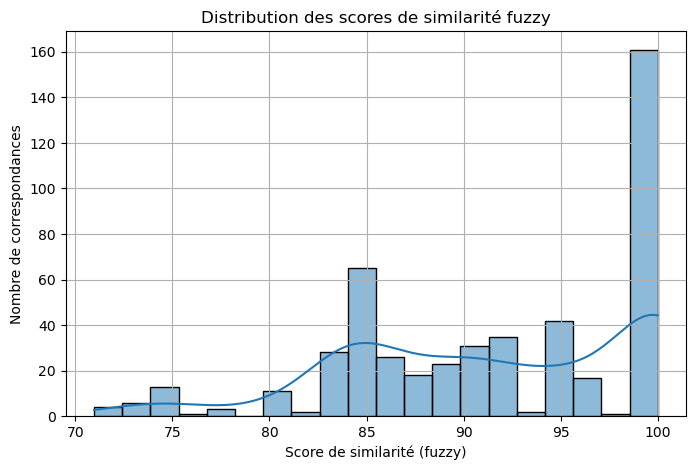

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(matched_df_fuzzy_set_sort2["Score"], bins=20, kde=True)
plt.title("Distribution des scores de similarité fuzzy")
plt.xlabel("Score de similarité (fuzzy)")
plt.ylabel("Nombre de correspondances")
plt.grid(True)
plt.show()


**Quelle méthode choisir ?**

✅ ***TF-IDF + Cosine Similarity*** → Si  on veut  un bon compromis entre rapidité et précision.

✅ ***TF-IDF + Cosine*** → Si les titres ont des reformulations différentes (ex: "Deep Learning in Medicine" vs "Medical Applications of Deep Learning") 

✅ ***RapidFuzz*** → Si on veut une solution rapide et facile à implémenter.

✅ ***Fuzzy Matching*** → Si les titres sont très proches (ex: quelques caractères changés) 

### 3️⃣ Approximate Nearest Neighbors (FAISS)

FAISS (Facebook AI Similarity Search) est une librairie très rapide pour la recherche de similarités entre des vecteurs de grande dimension. Il est utile lorsque l'on travaille avec un grand nombre de titres, car il est plus rapide que cosine_similarity sur des matrices volumineuses.

***Avantages***: Ultra rapide sur de gros jeux de données, et Recherche approximative efficace

***Incovénients***: Moins précis que cosine_similarity sur de petites bases, et, nécessite un ajustement du seuil best_score > 0.5

In [13]:
#pip install faiss-cpu

In [27]:
import faiss
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Chargement des fichiers
doc1 = pd.read_excel("chemin/vers/doc1.xlsx")  # Remplacer par le chemin réel
doc2 = pd.read_excel("chemin/vers/doc2.xlsx")  # Remplacer par le chemin réel

# Convertir les titres et les IDs en listes
titles_doc1 = doc1["Title"].astype(str).tolist()
titles_doc2 = doc2["form_title"].astype(str).tolist()
ids_doc2 = doc2["id"].astype(str).tolist()

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
tfidf_matrix = vectorizer.fit_transform(titles_doc1 + titles_doc2)

# Séparation des matrices
tfidf_doc1 = tfidf_matrix[:len(titles_doc1)].toarray().astype('float32')
tfidf_doc2 = tfidf_matrix[len(titles_doc1):].toarray().astype('float32')

# Création de l'index FAISS
dimension = tfidf_doc1.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(tfidf_doc2)  # Ajout des titres de doc2 dans l'index

# Recherche du plus proche voisin
k = 1
distances, indices = index.search(tfidf_doc1, k)

# Création des correspondances
matches = []
for i, (best_idx, best_dist) in enumerate(zip(indices.flatten(), distances.flatten())):
    best_score = 1 / (1 + best_dist)  # Conversion distance → score
    if best_score > 0.7:  # Seuil ajustable
        matches.append((titles_doc1[i], titles_doc2[best_idx], ids_doc2[best_idx], best_score))

# Création du DataFrame
matched_df_faiss2 = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])

# Sauvegarde
matched_df_faiss2.to_excel("resultats_faiss2.xlsx", index=False)

# Affichage
matched_df_faiss2


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,titre_doc_acm,titres_similaires_revconf,id_rev,Score
0,"ACM Conference on Health, Inference, and Learning","Conference on Health, Inference, and Learning",19386,0.974290
1,Annual Computer Security Applications Conference,Annual Computer Security Applications Conference,4258,1.000000
2,"AAAI/ACM Conference on AI, Ethics, and Society","AAAI/ACM Conference on AI, Ethics, and Society",6742,1.000000
3,IEEE/ACM International Conference on Automated...,IEEE/ACM International Conference on Automated...,3708,1.000000
4,ACM Asia Conference on Computer and Communicat...,ACM Asia Conference on Computer and Communicat...,341,1.000000
...,...,...,...,...
145,ACM Web Science Conference,ACM International Conference on Web Science,3887,0.945153
146,IEEE/WIC/ACM International Conference on Web I...,IEEE/WIC/ACM International Conference on Web I...,3681,1.000000
147,ACM Conference on Security and Privacy in Wire...,ACM Conference on Security and Privacy in Wire...,4507,1.000000
148,ACM International Conference on Web Search and...,ACM International Conference on Web Search and...,2072,1.000000


In [21]:
matched_df_faiss2.describe(include="all")

,titre_doc_acm,titres_similaires_revconf,id_rev,Score
count,150,150,150,150.000000
unique,150,144,144,NaN
top,"ACM Conference on Health, Inference, and Learning",International Conference of Machine Learning,969,NaN
freq,1,3,3,NaN
mean,NaN,NaN,NaN,0.953734
std,NaN,NaN,NaN,0.079501
min,NaN,NaN,NaN,0.708651
25%,NaN,NaN,NaN,0.946021
50%,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,1.000000


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


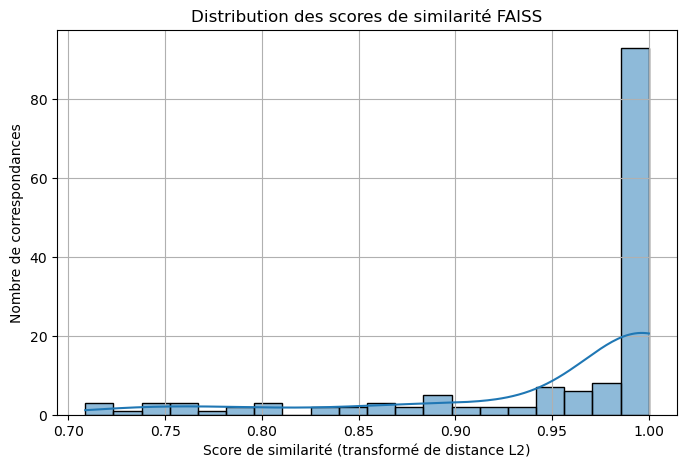

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(matched_df_faiss2["Score"], bins=20, kde=True)
plt.title("Distribution des scores de similarité FAISS")
plt.xlabel("Score de similarité (transformé de distance L2)")
plt.ylabel("Nombre de correspondances")
plt.grid(True)
plt.show()

### 4️⃣ Scikit-Learn (méthode LSA)

Latent Semantic Analysis (LSA) avec SVD
LSA permet de capturer la sémantique derrière les titres en réduisant la dimension des vecteurs TF-IDF.

In [23]:
# pip install openpyxl

In [32]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# Chargement des fichiers
doc1 = pd.read_excel("chemin/vers/doc1.xlsx")  # Remplacer par le chemin réel
doc2 = pd.read_excel("chemin/vers/doc2.xlsx")  # Remplacer par le chemin réel

# Conversion des titres et des IDs
titles_doc1 = doc1["Title"].astype(str).tolist()
titles_doc2 = doc2["form_title"].astype(str).tolist()
ids_doc2 = doc2["id"].astype(str).tolist()

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
tfidf_matrix = vectorizer.fit_transform(titles_doc1 + titles_doc2)

# Réduction de dimension avec LSA (SVD)
svd = TruncatedSVD(n_components=100)
lsa_matrix = svd.fit_transform(tfidf_matrix)

# Séparation des matrices
lsa_doc1 = lsa_matrix[:len(titles_doc1)]
lsa_doc2 = lsa_matrix[len(titles_doc1):]

# Calcul de la similarité cosinus
cosine_sim = cosine_similarity(lsa_doc1, lsa_doc2)

# Récupération des meilleurs appariements
matches = []
for i, titre in enumerate(titles_doc1):
    best_idx = np.argmax(cosine_sim[i])
    best_score = cosine_sim[i][best_idx]

    if best_score > 0.7:  # Seuil ajustable
        matches.append((titre, titles_doc2[best_idx], ids_doc2[best_idx], best_score))

# Création du DataFrame
matched_df_lsa2 = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])

# Sauvegarde
matched_df_lsa2.to_excel("resultats_lsa2.xlsx", index=False)

# Affichage
matched_df_lsa2


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,titre_doc_acm,titres_similaires_revconf,id_rev,Score
0,Africa-Asia Dialogue Network (AADN) Internatio...,International Conference on Management of Emer...,4586,0.749234
1,"International Conference on Algorithms, Comput...",International Conference on Artificial Intelli...,4637,0.842511
2,Australasian Computing Education Conference,Computing Frontiers Conference,282,0.922088
3,International Conference on Animal-Computer In...,Australasian Computer-Human Interaction Confer...,19308,0.889287
4,International Virtual Conference on Applied Co...,3rd International Conference on Information an...,1645,0.737910
...,...,...,...,...
451,Winter Simulation Conference,The 19th ACM International Conference on Model...,289,0.795614
452,ACM International Conference on Web Search and...,ACM International Conference on Web Search and...,2072,1.000000
453,World Symposium on Software Engineering,International Symposium on Software Engineerin...,3239,0.758860
454,International Conference on Underwater Network...,International Conference on Future Networks an...,19679,0.843768


In [25]:
matched_df_lsa2.describe(include="all")

,titre_doc_acm,titres_similaires_revconf,id_rev,Score
count,458,458,458,458.000000
unique,458,272,210,NaN
top,Africa-Asia Dialogue Network (AADN) Internatio...,International Conference on Artificial Intelli...,4637,NaN
freq,1,18,23,NaN
mean,NaN,NaN,NaN,0.890570
std,NaN,NaN,NaN,0.100051
min,NaN,NaN,NaN,0.700585
25%,NaN,NaN,NaN,0.797600
50%,NaN,NaN,NaN,0.901461
75%,NaN,NaN,NaN,0.996091


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


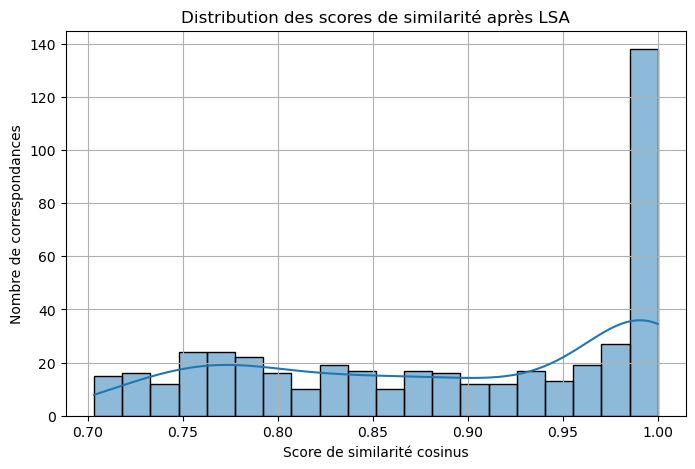

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(matched_df_lsa2["Score"], bins=20, kde=True)
plt.title("Distribution des scores de similarité après LSA")
plt.xlabel("Score de similarité cosinus")
plt.ylabel("Nombre de correspondances")
plt.grid(True)
plt.show()


***Paramètres principaux dans LSA :***

***n_components*** (Nombre de dimensions pour la réduction)
        Description : Définit le nombre de composantes principales à garder après la décomposition SVD.
        Valeur par défaut : 2
        Conseil : En général, plus la valeur est élevée, plus l'approximation est fidèle aux données d'origine, mais il y a un compromis avec la performance.
        Ajustement : Si  beaucoup de bruit ou de variabilité dans les titres, tu peux essayer une valeur plus élevée (ex: n_components=100).

***n_iter*** (Nombre d'itérations pour la décomposition)
        Description : Nombre d'itérations pour la convergence dans le cas d'une décomposition itérative.
        Valeur par défaut : 5
        Conseil : Augmenter ce paramètre peut améliorer la convergence, mais il n'est généralement pas nécessaire si tes données sont bien préparées.

***random_state***
        Description : Valeur de l'état aléatoire pour garantir la reproductibilité des résultats.
        Valeur par défaut : None
        Conseil : Fixe un nombre entier pour des résultats reproductibles, par exemple random_state=42.

***tol*** (Tolérance de convergence)
        Description : Définit la tolérance pour la convergence des valeurs singulières. Plus il est bas, plus l'algorithme va essayer d'être précis.
        Valeur par défaut : 0.0
        Conseil : Ajuster la tolérance peut affecter la performance et la précision. Si l'algorithme est trop long à converger, augmenter cette valeur.

***svd_solver***
        Description : Choix de l'algorithme utilisé pour la décomposition SVD. Les options incluent :
        auto : Choisit automatiquement la meilleure méthode.
        full : Utilise une méthode exacte basée sur les valeurs singulières.
        randomized : Utilise une approche approximative (plus rapide pour des grands jeux de données).
        Valeur par défaut : auto

        
Conseil : Utiliser randomized si  très grands jeux de données pour de meilleures performances.

### 5️⃣ Word Embeddings avec Word2Vec ou FastText

Pour capturer le sens des mots, je peux utiliser des modèles pré-entraînés comme Word2Vec ou FastText pour encoder les titres et ensuite utiliser Cosine Similarity ou FAISS pour la recherche

In [36]:
from gensim.models import FastText
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Chargement des fichiers
doc1 = pd.read_excel("chemin/vers/doc1.xlsx")  # Remplacer par le chemin réel
doc2 = pd.read_excel("chemin/vers/doc2.xlsx")  # Remplacer par le chemin réel

# Préparation des titres et des IDs
titles_doc1 = doc1["Title"].astype(str).tolist()
titles_doc2 = doc2["form_title"].astype(str).tolist()
ids_doc2 = doc2["id"].astype(str).tolist()

# Tokenisation
tokenized_titles_doc1 = [titre.split() for titre in titles_doc1]
tokenized_titles_doc2 = [titre.split() for titre in titles_doc2]

# Entraînement FastText
model = FastText(sentences=tokenized_titles_doc1 + tokenized_titles_doc2, vector_size=100, window=5, min_count=1, workers=4)

# Fonction d'embedding moyen
def get_embedding(title):
    vectors = [model.wv[word] for word in title.split() if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Calcul des embeddings
embeddings_doc1 = np.array([get_embedding(titre) for titre in titles_doc1])
embeddings_doc2 = np.array([get_embedding(titre) for titre in titles_doc2])

# Similarité cosinus
cosine_sim = cosine_similarity(embeddings_doc1, embeddings_doc2)

# Récupération des meilleurs appariements
matches = []
for i, titre in enumerate(titles_doc1):
    best_idx = np.argmax(cosine_sim[i])
    best_score = cosine_sim[i][best_idx]

    if best_score > 0.7:
        matches.append((titre, titles_doc2[best_idx], ids_doc2[best_idx], best_score))

# DataFrame des correspondances
matched_df_word2vec2 = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])

# Export
matched_df_word2vec2.to_excel("resultats_word2vec2.xlsx", index=False)

# Affichage
matched_df_word2vec2


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,titre_doc_acm,titres_similaires_revconf,id_rev,Score
0,Africa-Asia Dialogue Network (AADN) Internatio...,18th International Conference on Real-Time and...,612,0.999959
1,"International Conference on Algorithms, Comput...",HSCC - 17th International Conference on Hybrid...,1002,0.999933
2,Australasian Computing Education Conference,"SNC, conference on Symbolic-Numeric Computation",1128,0.999225
3,International Conference on Animal-Computer In...,International Conference on Compiler Construction,178,0.999876
4,International Virtual Conference on Applied Co...,ACM International Conference on Hybrid Systems...,1002,0.999868
...,...,...,...,...
497,Winter Simulation Conference,Digital Automation Conference,3707,0.999431
498,ACM International Conference on Web Search and...,ACM International Conference on Web Search and...,2072,1.000000
499,World Symposium on Software Engineering,MiSE '16 - 8th International Workshop on Model...,3507,0.999881
500,International Conference on Underwater Network...,International Conference on Real-Time Networks...,612,0.999935


In [37]:
matched_df_word2vec2.describe(include="all")

,titre_doc_acm,titres_similaires_revconf,id_rev,Score
count,502,502,502,502.000000
unique,501,355,203,NaN
top,International Conference on Computing and Data...,International Conference on Information and Kn...,483,NaN
freq,2,11,19,NaN
mean,NaN,NaN,NaN,0.999887
std,NaN,NaN,NaN,0.000183
min,NaN,NaN,NaN,0.997594
25%,NaN,NaN,NaN,0.999876
50%,NaN,NaN,NaN,0.999929
75%,NaN,NaN,NaN,0.999965


C:\Users\abapst\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


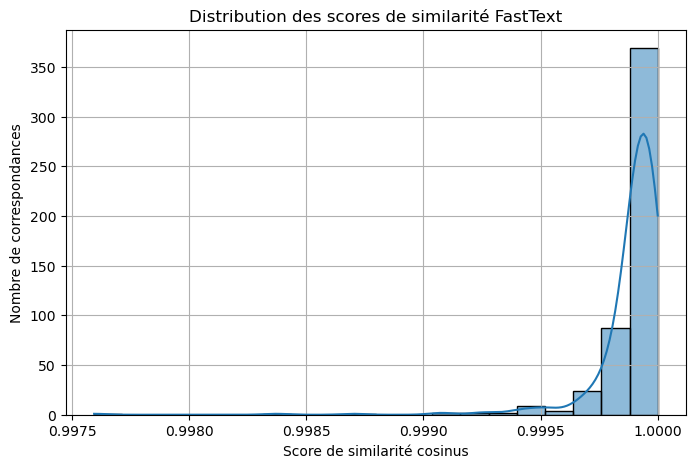

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(matched_df_word2vec2["Score"], bins=20, kde=True)
plt.title("Distribution des scores de similarité FastText")
plt.xlabel("Score de similarité cosinus")
plt.ylabel("Nombre de correspondances")
plt.grid(True)
plt.show()


Word Embeddings (FastText ou Word2Vec)

Les Word Embeddings représentent les mots sous forme de vecteurs dans un espace continu, permettant de capturer des relations sémantiques et syntaxiques entre les mots.
Paramètres principaux dans Word Embeddings (avec FastText ou Word2Vec) :
a) Paramètres communs pour Word2Vec et FastText :

***vector_size*** (Dimension des vecteurs de mots)
        Description : Définit la dimensionnalité des vecteurs de mots. Des valeurs plus élevées permettent de capturer plus de sémantique mais augmentent la mémoire           et les coûts de calcul.
        Valeur par défaut : 100
        Conseil : Commence avec 100 et augmente jusqu'à 300 ou plus pour des données plus complexes.

***window*** (Fenêtre contextuelle)
        Description : Taille de la fenêtre de contexte autour du mot cible pour la prédiction du mot. Plus grand est ce paramètre, 
        plus le modèle peut capturer de relations à longue portée.
        Valeur par défaut : 5
        Conseil : Pour des textes plus longs ou riches, une valeur plus grande (ex: window=10) peut être bénéfique.

***min_count*** (Fréquence minimale des mots)
        Description : Ignore les mots qui apparaissent moins souvent que cette valeur.
        Valeur par défaut : 5
        Conseil : Une valeur plus petite capte plus de mots, mais introduit plus de bruit. Une valeur plus grande aide à éliminer les mots peu fréquents.

***workers*** (Nombre de threads pour le calcul parallèle)
        Description : Nombre de threads pour accélérer l'entraînement en utilisant plusieurs processeurs.
        Valeur par défaut : 3
        Conseil : Augmente-le si tu as plusieurs cœurs de processeur disponibles.

***epochs*** (Nombre d'époques d'entraînement)
        Description : Le nombre de fois que l'algorithme parcourt l'ensemble de données.
        Valeur par défaut : 5
        Conseil : Plus d'époques peuvent améliorer la qualité des embeddings mais augmentent le temps d'entraînement. Essaye des valeurs comme 10 ou 15.

***sg*** (Skip-gram vs CBOW)
        Description : Définit l'architecture de l'algorithme :
        0 : Continuous Bag of Words (CBOW)
        1 : Skip-Gram
        Valeur par défaut : 0 (CBOW)
        Conseil : sg=1 est souvent préférable pour les petites bases de données ou quand tu veux une meilleure qualité de mots rares.

***negative*** (Nombre d'échantillons négatifs)
        Description : Nombre d'échantillons négatifs pour l'entraînement, utilisé dans le cadre 
        de l'entraînement avec des échantillons négatifs (notion de "noise-    contrastive estimation").
        Valeur par défaut : 5
        Conseil : Augmenter la valeur peut améliorer la qualité des embeddings dans des contextes plus complexes.

***subsample*** (Taux de sous-échantillonnage)
        Description : Proportion de mots fréquents à supprimer. Peut améliorer la qualité des embeddings en réduisant le bruit.
        Valeur par défaut : 1e-3
        Conseil : Réduit cette valeur pour éliminer les mots très fréquents et améliorer la représentation des mots rares.

## Comparaison entre les différentes méthodes:

In [ ]:
## Script comparatif multi-méthodes complet

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from rapidfuzz import process, fuzz
import faiss
from gensim.models import FastText
import matplotlib.pyplot as plt
from collections import Counter

# --- Configuration ---
path_doc1 = "chemin/vers/doc1.xlsx"
path_doc2 = "chemin/vers/doc2.xlsx"
score_threshold = 0.7  # Seuil commun aux méthodes cosine/FAISS, 70 pour RapidFuzz

# --- Chargement données ---
doc1 = pd.read_excel(path_doc1)
doc2 = pd.read_excel(path_doc2)

titles_doc1 = doc1["Title"].astype(str).tolist()
titles_doc2 = doc2["form_title"].astype(str).tolist()
ids_doc2 = doc2["id"].astype(str).tolist()

# ----------- Méthode 1 : TF-IDF + Cosine -----------
def method_tfidf_cosine():
    vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(titles_doc1 + titles_doc2)
    tfidf_doc1 = tfidf_matrix[:len(titles_doc1)]
    tfidf_doc2 = tfidf_matrix[len(titles_doc1):]
    cosine_sim = cosine_similarity(tfidf_doc1, tfidf_doc2)

    matches = []
    match_count = {}
    for i, titre in enumerate(titles_doc1):
        best_idx = np.argmax(cosine_sim[i])
        best_score = cosine_sim[i][best_idx]
        if best_score > score_threshold:
            match_id = ids_doc2[best_idx]
            matches.append((titre, titles_doc2[best_idx], match_id, best_score))
            match_count[titre] = match_count.get(titre, 0) + 1
    df = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])
    df["nbre_occurences"] = df["titre_doc1"].map(match_count).astype(str)
    return df

# ----------- Méthode 2 : RapidFuzz token_sort_ratio -----------
def method_rapidfuzz_token_sort():
    matches = []
    match_count = {}
    for titre in titles_doc1:
        match, score, idx = process.extractOne(titre, titles_doc2, scorer=fuzz.token_sort_ratio)
        if score > 70:
            match_id = ids_doc2[idx]
            matches.append((titre, match, match_id, score))
            match_count[titre] = match_count.get(titre, 0) + 1
    df = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])
    df["nbre_occurences"] = df["titre_doc1"].map(match_count).astype(str)
    return df

# ----------- Méthode 3 : RapidFuzz token_set_ratio -----------
def method_rapidfuzz_token_set():
    matches = []
    match_count = {}
    for titre in titles_doc1:
        match, score, idx = process.extractOne(titre, titles_doc2, scorer=fuzz.token_set_ratio)
        if score > 70:
            match_id = ids_doc2[idx]
            matches.append((titre, match, match_id, score))
            match_count[titre] = match_count.get(titre, 0) + 1
    df = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])
    df["nbre_occurences"] = df["titre_doc1"].map(match_count).astype(str)
    return df

# ----------- Méthode 4 : RapidFuzz max(token_sort_ratio, token_set_ratio) -----------
def method_rapidfuzz_max_token():
    matches = []
    for titre in titles_doc1:
        match, score, idx = process.extractOne(
            titre, titles_doc2, 
            scorer=lambda a,b,score_cutoff=0: max(fuzz.token_sort_ratio(a,b), fuzz.token_set_ratio(a,b))
        )
        if score > 70:
            match_id = ids_doc2[idx]
            matches.append((titre, match, match_id, score))
    df = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])
    titre_counts = Counter(df["titre_doc1"])
    df["nbre_occurences"] = df["titre_doc1"].map(titre_counts)
    return df

# ----------- Méthode 5 : FAISS TF-IDF + L2 -----------
def method_faiss():
    vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(titles_doc1 + titles_doc2)
    tfidf_doc1 = tfidf_matrix[:len(titles_doc1)].toarray().astype('float32')
    tfidf_doc2 = tfidf_matrix[len(titles_doc1):].toarray().astype('float32')

    dimension = tfidf_doc1.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(tfidf_doc2)

    k = 1
    distances, indices = index.search(tfidf_doc1, k)

    matches = []
    for i, (best_idx, best_dist) in enumerate(zip(indices.flatten(), distances.flatten())):
        best_score = 1 / (1 + best_dist)
        if best_score > score_threshold:
            matches.append((titles_doc1[i], titles_doc2[best_idx], ids_doc2[best_idx], best_score))
    df = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])
    return df

# ----------- Méthode 6 : LSA + cosine -----------
def method_lsa():
    vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(titles_doc1 + titles_doc2)
    svd = TruncatedSVD(n_components=100)
    lsa_matrix = svd.fit_transform(tfidf_matrix)
    lsa_doc1 = lsa_matrix[:len(titles_doc1)]
    lsa_doc2 = lsa_matrix[len(titles_doc1):]
    cosine_sim = cosine_similarity(lsa_doc1, lsa_doc2)

    matches = []
    for i, titre in enumerate(titles_doc1):
        best_idx = np.argmax(cosine_sim[i])
        best_score = cosine_sim[i][best_idx]
        if best_score > score_threshold:
            matches.append((titre, titles_doc2[best_idx], ids_doc2[best_idx], best_score))
    df = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])
    return df

# ----------- Méthode 7 : FastText + cosine -----------
def method_fasttext():
    tokenized_doc1 = [titre.split() for titre in titles_doc1]
    tokenized_doc2 = [titre.split() for titre in titles_doc2]

    model = FastText(sentences=tokenized_doc1 + tokenized_doc2, vector_size=100, window=5, min_count=1, workers=4)

    def get_embedding(title):
        vectors = [model.wv[word] for word in title.split() if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

    embeddings_doc1 = np.array([get_embedding(titre) for titre in titles_doc1])
    embeddings_doc2 = np.array([get_embedding(titre) for titre in titles_doc2])

    cosine_sim = cosine_similarity(embeddings_doc1, embeddings_doc2)

    matches = []
    for i, titre in enumerate(titles_doc1):
        best_idx = np.argmax(cosine_sim[i])
        best_score = cosine_sim[i][best_idx]
        if best_score > score_threshold:
            matches.append((titre, titles_doc2[best_idx], ids_doc2[best_idx], best_score))
    df = pd.DataFrame(matches, columns=["titre_doc1", "titre_similaire_doc2", "id_doc2", "score"])
    return df

# --- Exécution de toutes les méthodes ---
results = {}

print("Exécution méthode TF-IDF + cosine...")
results["TF-IDF cosine"] = method_tfidf_cosine()

print("Exécution méthode RapidFuzz token_sort_ratio...")
results["RapidFuzz token_sort_ratio"] = method_rapidfuzz_token_sort()

print("Exécution méthode RapidFuzz token_set_ratio...")
results["RapidFuzz token_set_ratio"] = method_rapidfuzz_token_set()

print("Exécution méthode RapidFuzz max(token_sort_ratio, token_set_ratio)...")
results["RapidFuzz max(token_sort_ratio, token_set_ratio)"] = method_rapidfuzz_max_token()

print("Exécution méthode FAISS TF-IDF + L2...")
results["FAISS TF-IDF L2"] = method_faiss()

print("Exécution méthode LSA + cosine...")
results["LSA cosine"] = method_lsa()

print("Exécution méthode FastText + cosine...")
results["FastText cosine"] = method_fasttext()

# --- Création d'un tableau récapitulatif ---
summary = []
for method_name, df in results.items():
    summary.append({
        "Méthode": method_name,
        "Nb Matches > seuil": len(df),
        "Score moyen": df["score"].mean() if not df.empty else 0,
        "Score min": df["score"].min() if not df.empty else 0,
        "Score max": df["score"].max() if not df.empty else 0,
    })
summary_df = pd.DataFrame(summary)

print("\n--- Résumé des performances ---")
print(summary_df)

# --- Graphique des matches ---
plt.figure(figsize=(10,6))
plt.bar(summary_df["Méthode"], summary_df["Nb Matches > seuil"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title(f"Nombre de correspondances supérieures au seuil ({score_threshold})")
plt.ylabel("Nombre de matches")
plt.tight_layout()
plt.show()
